In [1]:
dataset = {
    0: "./inpainting_dataset",  # parent folder expected to contain 'inpainted' and 'masks'
    1: "./finetune_dataset/test"        # parent folder; should have 'inpainted' and 'masks'
}

In [2]:
demonstrative = True
# Parameters for anomaly scoring visualization
model_checkpoint = "lmms-lab/llava-onevision-qwen2-0.5b-ov"  # or local path
size = "05b"  # or "7b"
images_dir = dataset[int(demonstrative)]  # this is now the PARENT folder
pattern = "*.*"  # glob pattern
max_side = 1024
show_n = 12  # number of images to visualize (sorting functionality retained)
sort_by_score = True  # if True, show top-N highest scores; else first N
images_dir

'./finetune_dataset/test'

In [3]:
#open json file

import json
with open('config.json') as f:
    config = json.load(f)

image_grid_pinpoints = config["image_grid_pinpoints"]
image_aspect_ratio = config["image_aspect_ratio"]

FileNotFoundError: [Errno 2] No such file or directory: 'config.json'

In [4]:

from glob import glob
from PIL import Image
import os, torch
from custom_anomaly_detector import OVAnomalyDetector, build_ov_anomaly_detector
from utils_trends.image_processing import process_images
from llava.model.anomaly_expert import AnomalyOV
from utils_trends.vulnerability_map import predict_with_model, adversarial_recompute
from utils_trends.visualization import visualize_anomaly_gradcam
from utils_trends.metrics import compute_mask_anomaly_metrics, MetricsAverages

# Derive inpainted and masks subfolders from parent
inpainted_dir = os.path.join(images_dir, 'inpainted')
masks_dir = os.path.join(images_dir, 'masks')
if not os.path.isdir(inpainted_dir):
    raise SystemExit(f"Inpainted folder not found: {inpainted_dir}")
if not os.path.isdir(masks_dir):
    print(f"Warning: Masks folder not found: {masks_dir}. Mask visualization will be skipped.")

device = "mps"
# Load model
model_name = "llava_qwen"
"""
vision_tower_name: str = "google/siglip-so400m-patch14-384",
    anomaly_expert_path: str = "./pretrained_expert_7b.pth",
    mm_projector_type: str = "mlp2x_gelu",
    mm_hidden_size: int = 1152,
    hidden_size: int = 896,
    device: str = "cuda",
    dtype: Any | None = None,
    load_pretrained_projector: Any | None = None,
    device_map: str = "auto"
"""
# model, image_processor = build_ov_anomaly_detector(
#     vision_tower_name="google/siglip-so400m-patch14-384",
#     anomaly_expert_path='./pretrained_expert_05b.pth' if size != '7b' else './pretrained_expert_7b.pth',
#     mm_projector_type="mlp2x_gelu",
#     mm_hidden_size=1152,
#     hidden_size=896,
#     device=device,
#     dtype=torch.float32,
#     device_map="auto"
# )

# model.save_checkpoint("./zs_checkpoint.pt")
model, image_processor = OVAnomalyDetector.load_from_checkpoint("./checkpoints/best_model.pt", device=device)
# model, image_processor = OVAnomalyDetector.load_from_checkpoint("./zs_checkpoint.pt", device=device)

model.eval()



# Collect images ONLY from inpainted subfolder now
image_paths = sorted([
    p for p in glob(os.path.join(inpainted_dir, '**', pattern), recursive=True)
    if os.path.isfile(p)
])
print(f"Found {len(image_paths)} inpainted images in {inpainted_dir}")
if not image_paths:
    raise SystemExit("No inpainted images found. Adjust parent folder or pattern.")

ModuleNotFoundError: No module named 'custom_anomaly_detector'

In [5]:
# Sampling removed: use ALL inpainted images
image_paths_subset = image_paths  # keep variable name for downstream compatibility
print(f"Using all {len(image_paths_subset)} images for scoring and mask visualization.")

# Optional: quick check of mask correspondence count
missing_masks = 0
for p in image_paths_subset:
    mp = os.path.join(masks_dir, os.path.basename(p))
    if not os.path.isfile(mp):
        missing_masks += 1
if missing_masks:
    print(f"Warning: {missing_masks} masks missing out of {len(image_paths_subset)} images.")

Using all 933 images for scoring and mask visualization.


In [6]:
def get_image(img_path:str, device, max_side=1024):
    img = Image.open(img_path).convert('RGB')
    # Load corresponding mask (single full-image mask)
    mask_path = os.path.join(masks_dir, os.path.basename(img_path))
    mask_img = Image.open(mask_path).convert('L') if os.path.isfile(mask_path) else None

    if max(img.size) > max_side:
        if img.width > img.height:
            new_w = max_side
            new_h = int(max_side * img.height / img.width)
        else:
            new_h = max_side
            new_w = int(max_side * img.width / img.height)
        img = img.resize((new_w, new_h))
    image_tensor = process_images([img], image_processor, image_aspect_ratio, image_grid_pinpoints).to(device)
    mask_tensor = process_images([mask_img], image_processor, image_aspect_ratio, image_grid_pinpoints).to(device)
    return image_tensor, mask_tensor


In [7]:
# Compute anomaly scores for ALL inpainted images now (sampling removed)
import numpy as np
from tqdm import tqdm
scores = []
metrics_results = []  # store per-image metrics
break_at = 50

# Toggle adversarial computation
compute_adversarial = False  # Set to False to skip adversarial attack computation

# Metrics aggregator class


metrics_agg_original = MetricsAverages()  # For original anomaly maps
metrics_agg_output = MetricsAverages()    # For output difference maps (only if compute_adversarial=True)

# Attack hyperparameters (only used if compute_adversarial=True)
attack_epsilon = 0.05  # norm bound
attack_top_k = 0.50    # fraction for M_topk
attack_noise_mode = 'random'  # 'random' or 'structured'

for idx, img_path in enumerate(tqdm(image_paths_subset, desc="Processing images"), 1):
    image_tensor, mask_tensor = get_image(img_path, device)
    # print(f"mask shape: {mask_tensor.shape}")
    W, H = image_tensor.shape[3:]

    # print(f"width: {W}, height: {H}, device: {image_tensor.device}")
    with torch.no_grad():
        score, attn_maps, anomaly_maps, vuln_map, image_tensor = predict_with_model(
            model=model,
            image_tensor=image_tensor,
            device=device,
            max_side=1024,
            anomaly_map_size=(W,H),
        )
    # print(f"Processed image tensor shape: {image_tensor.shape}")

    # Compute metrics on ORIGINAL anomaly map
    metrics_original = compute_mask_anomaly_metrics(
        anomaly_maps=anomaly_maps,
        mask_image=mask_tensor,
        top_k=0.50,
        aggregate='mean',
        white_threshold=None,
        inpainted_is_white=True,
    )
    metrics_agg_original.update(metrics_original)

    # Adversarial attack + recompute anomaly map (optional)
    if compute_adversarial:
        attacked_image, anomaly_maps_adv, output_map = adversarial_recompute(
            model=model,
            image_tensor=image_tensor,
            original_anomaly_maps=anomaly_maps,
            device=device,
            epsilon=attack_epsilon,
            top_k=attack_top_k,
            noise_mode=attack_noise_mode,
        )

        # Compute metrics on OUTPUT difference map
        metrics_output = compute_mask_anomaly_metrics(
            anomaly_maps=output_map,
            mask_image=mask_tensor,
            top_k=0.50,
            aggregate='mean',
            white_threshold=None,
            inpainted_is_white=True,
        )
        metrics_agg_output.update(metrics_output)
    else:
        metrics_output = None
        output_map = None
        anomaly_maps_adv = None
    
    metrics_results.append((img_path, {'original': metrics_original, 'output': metrics_output}))

    # Prepare metrics label with two decimals (showing both)
    def f2(x):
        return 'nan' if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{float(x):.2f}"
    
    if compute_adversarial and metrics_output is not None:
        metrics_label = (
            f"Original: IoU={f2(metrics_original.get('iou_topk'))} Mass={f2(metrics_original.get('mass_frac'))} "
            f"ROC={f2(metrics_original.get('roc_auc'))} PR={f2(metrics_original.get('pr_auc'))} | "
       
            f"Output Δ: IoU={f2(metrics_output.get('iou_topk'))} Mass={f2(metrics_output.get('mass_frac'))} "
            f"ROC={f2(metrics_output.get('roc_auc'))} PR={f2(metrics_output.get('pr_auc'))} "
            f"score={score:.4f}"
        )
    else:
        metrics_label = (
            f"Original: IoU={f2(metrics_original.get('iou_topk'))} Mass={f2(metrics_original.get('mass_frac'))} "
            f"ROC={f2(metrics_original.get('roc_auc'))} PR={f2(metrics_original.get('pr_auc'))} "
            f"score={score:.4f}"
        )
    # print(f"Metrics for image {idx}:")
    # print(f"  Original anomaly: IoU={f2(metrics_original.get('iou_topk'))}, Mass={f2(metrics_original.get('mass_frac'))}, ROC={f2(metrics_original.get('roc_auc'))}, PR={f2(metrics_original.get('pr_auc'))}")
    # print(f"  Output Δ map:     IoU={f2(metrics_output.get('iou_topk'))}, Mass={f2(metrics_output.get('mass_frac'))}, ROC={f2(metrics_output.get('roc_auc'))}, PR={f2(metrics_output.get('pr_auc'))}")

    # Updated visualization with Adv Anomaly and Output |Δ| Map (single metrics label)
    # fig = visualize_anomaly_gradcam(
    #     image_tensor,
    #     anomaly_maps,
    #     vuln_maps=vuln_map if len(vuln_map) > 0 else None,
    #     mask_image=mask_tensor,
    #     anomaly_maps_adv=anomaly_maps_adv,
    #     output_maps=output_map,
    #     alpha=0.5,
    #     metrics_label=metrics_label,
    # )
    if idx == break_at:
        break
    scores.append((img_path, score))
    # if idx % 20 == 0:
    #     print(f"[{idx}] {img_path} -> {score:.6f}")

print(f"\nScored {len(scores)} images")
scores_array = np.array([[s[0], s[1]] for s in scores], dtype=object)

# Calculate precision of anomaly scores


print("\n=== Average Metrics ===")
print("Original anomaly maps:", str(metrics_agg_original))
if compute_adversarial:
    print("Output difference maps:", str(metrics_agg_output))
else:
    print("Adversarial metrics: SKIPPED (compute_adversarial=False)")

Processing images:   5%|▌         | 49/933 [01:33<28:15,  1.92s/it]


Scored 49 images

=== Average Metrics ===
Original anomaly maps: iou_topk=0.3022, mass_frac=0.4963, pr_auc=0.4036, roc_auc=0.5220
Adversarial metrics: SKIPPED (compute_adversarial=False)


In [8]:
scores_only = [s[1] for s in scores]
score_mean = np.mean(scores_only)
score_std = np.std(scores_only)
score_min = np.min(scores_only)
score_max = np.max(scores_only)

print("\n=== Anomaly Score Precision ===")
print(f"Mean:   {score_mean:.6f}")
print(f"Std:    {score_std:.6f}")
print(f"Min:    {score_min:.6f}")
print(f"Max:    {score_max:.6f}")
print(f"Range:  {score_max - score_min:.6f}")


=== Anomaly Score Precision ===
Mean:   0.538778
Std:    0.289365
Min:    0.029541
Max:    0.972656
Range:  0.943115


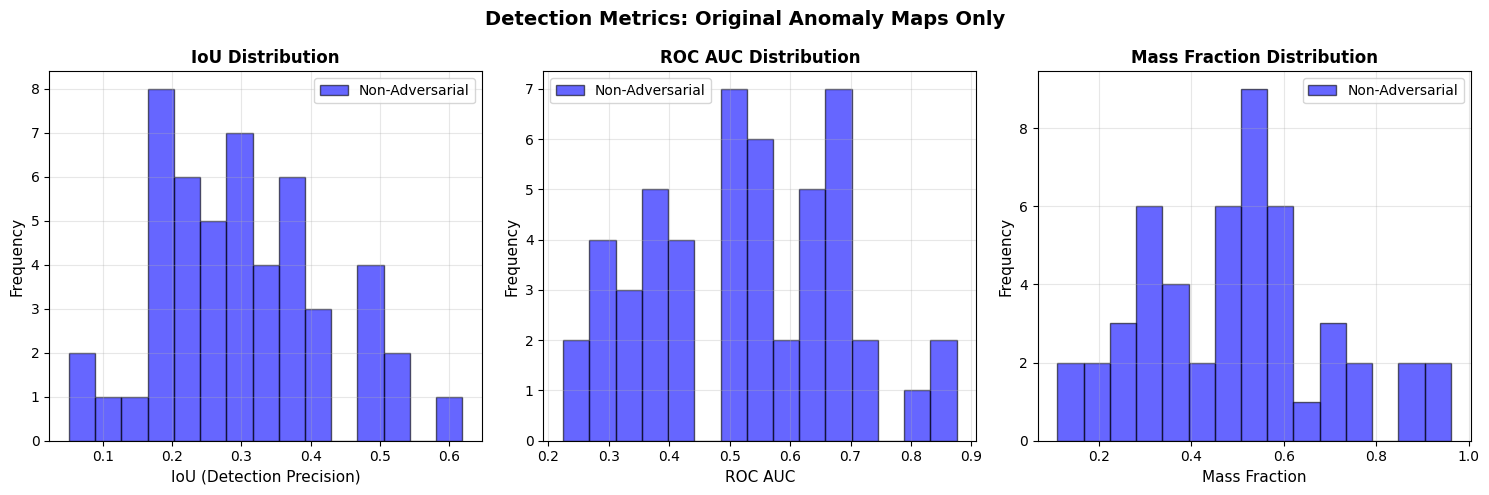


=== Summary Statistics ===

Metric               Type                 Mean       Std        Min        Max       
----------------------------------------------------------------------
IoU                  Non-Adversarial      0.3022     0.1226     0.0510     0.6187    

ROC AUC              Non-Adversarial      0.5220     0.1617     0.2245     0.8755    

Mass Fraction        Non-Adversarial      0.4963     0.2023     0.1101     0.9618    


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for histograms
iou_original = []
iou_adversarial = []
roc_original = []
roc_adversarial = []
mass_original = []
mass_adversarial = []

for img_path, metrics_dict in metrics_results:
    # Original (non-adversarial)
    iou_val = metrics_dict['original'].get('iou_topk')
    roc_val = metrics_dict['original'].get('roc_auc')
    mass_val = metrics_dict['original'].get('mass_frac')
    
    if iou_val is not None and not (isinstance(iou_val, float) and np.isnan(iou_val)):
        iou_original.append(iou_val)
    if roc_val is not None and not (isinstance(roc_val, float) and np.isnan(roc_val)):
        roc_original.append(roc_val)
    if mass_val is not None and not (isinstance(mass_val, float) and np.isnan(mass_val)):
        mass_original.append(mass_val)
    
    # Adversarial (output) - only if compute_adversarial=True
    if compute_adversarial and metrics_dict['output'] is not None:
        iou_adv = metrics_dict['output'].get('iou_topk')
        roc_adv = metrics_dict['output'].get('roc_auc')
        mass_adv = metrics_dict['output'].get('mass_frac')
        
        if iou_adv is not None and not (isinstance(iou_adv, float) and np.isnan(iou_adv)):
            iou_adversarial.append(iou_adv)
        if roc_adv is not None and not (isinstance(roc_adv, float) and np.isnan(roc_adv)):
            roc_adversarial.append(roc_adv)
        if mass_adv is not None and not (isinstance(mass_adv, float) and np.isnan(mass_adv)):
            mass_adversarial.append(mass_adv)

# Create figure with 3 subplots for the three metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
if compute_adversarial:
    fig.suptitle('Detection Metrics Comparison: Non-Adversarial vs Adversarial Images', fontsize=14, fontweight='bold')
else:
    fig.suptitle('Detection Metrics: Original Anomaly Maps Only', fontsize=14, fontweight='bold')

# IoU (Detection Precision) Histogram
axes[0].hist(iou_original, bins=15, alpha=0.6, label='Non-Adversarial', color='blue', edgecolor='black')
if compute_adversarial and iou_adversarial:
    axes[0].hist(iou_adversarial, bins=15, alpha=0.6, label='Adversarial', color='red', edgecolor='black')
axes[0].set_xlabel('IoU (Detection Precision)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('IoU Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ROC AUC Histogram
axes[1].hist(roc_original, bins=15, alpha=0.6, label='Non-Adversarial', color='blue', edgecolor='black')
if compute_adversarial and roc_adversarial:
    axes[1].hist(roc_adversarial, bins=15, alpha=0.6, label='Adversarial', color='red', edgecolor='black')
axes[1].set_xlabel('ROC AUC', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('ROC AUC Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Mass Fraction Histogram
axes[2].hist(mass_original, bins=15, alpha=0.6, label='Non-Adversarial', color='blue', edgecolor='black')
if compute_adversarial and mass_adversarial:
    axes[2].hist(mass_adversarial, bins=15, alpha=0.6, label='Adversarial', color='red', edgecolor='black')
axes[2].set_xlabel('Mass Fraction', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Mass Fraction Distribution', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===\n")
print(f"{'Metric':<20} {'Type':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)

def print_stats(data, metric_name, data_type):
    if data:
        mean = np.mean(data)
        std = np.std(data)
        min_val = np.min(data)
        max_val = np.max(data)
        print(f"{metric_name:<20} {data_type:<20} {mean:<10.4f} {std:<10.4f} {min_val:<10.4f} {max_val:<10.4f}")

print_stats(iou_original, "IoU", "Non-Adversarial")
if compute_adversarial and iou_adversarial:
    print_stats(iou_adversarial, "IoU", "Adversarial")
print()
print_stats(roc_original, "ROC AUC", "Non-Adversarial")
if compute_adversarial and roc_adversarial:
    print_stats(roc_adversarial, "ROC AUC", "Adversarial")
print()
print_stats(mass_original, "Mass Fraction", "Non-Adversarial")
if compute_adversarial and mass_adversarial:
    print_stats(mass_adversarial, "Mass Fraction", "Adversarial")